In [ ]:
pip install lifelines

In [ ]:
pip install scikit-survival

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.decomposition import FactorAnalysis
from sklearn.decomposition import PCA
from lifelines import LogLogisticAFTFitter, LogNormalAFTFitter, WeibullAFTFitter
from sklearn.model_selection import train_test_split
from sksurv.ensemble import RandomSurvivalForest
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#import eli5
#from eli5.sklearn import PermutationImportance
from scipy import stats
from lifelines.utils import k_fold_cross_validation

%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
aml = pd.read_csv('/content/AML_Bull.csv')
aml

,A1,A2,one,A3,A4,A5,A6,A7,A8,A9,...,A6276,A6277,A6278,A6279,A6280,A6281,A6282,A6283,A6284,A6285
0,3,1,1,0.082150,-0.02870,0.558300,0.50670,1.389000,0.793800,1.26300,...,-0.3048,0.33550,-0.06634,-0.71650,-1.112000,-0.602400,-0.42720,0.156800,0.116,-0.008710
1,243,1,1,-1.315000,-1.44700,-1.329000,1.13200,0.724700,0.387800,0.24570,...,0.3282,-0.38260,-0.74540,0.30740,0.352200,0.536500,1.06000,-0.074280,-1.042,0.526800
2,711,1,1,1.166000,0.66510,1.394000,-0.42760,-0.031536,-0.706400,-0.02246,...,-0.2870,-0.58280,-0.12560,-0.73180,-0.935000,-0.225700,-0.84750,1.042000,2.213,0.409148
3,663,1,1,0.255200,-0.01561,0.392400,1.51500,0.258800,1.612000,1.32300,...,-0.1907,0.25750,0.20970,0.36360,0.649300,0.158470,0.88890,0.057589,-1.236,0.068980
4,720,0,1,0.623300,-1.11200,-1.848000,-1.00500,0.490127,1.048000,1.07800,...,-0.8256,-0.46840,-0.39940,-0.02435,0.061420,-0.036934,-0.69710,0.189900,1.019,-0.412793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,206,0,1,-0.305521,-1.36800,-1.351000,-0.05152,0.526100,0.316300,0.22580,...,-0.5086,0.06535,0.39670,1.63800,2.149000,-0.186400,0.60720,-0.559900,0.271,0.019524
111,622,0,1,-0.090860,-1.05400,0.011340,0.07144,0.922000,-0.333204,0.15770,...,-0.5207,-0.52270,-1.14400,-1.14800,-0.556061,-1.222000,0.22410,0.187100,-0.827,0.449800
112,281,1,1,0.448600,0.45290,-0.131750,0.31340,-1.160000,-0.825626,-0.15530,...,-0.2777,-0.37670,-0.05200,-0.22824,0.603920,-4.199000,-1.72100,0.140100,-1.172,-1.006720
113,33,1,1,-0.072010,0.83210,0.141735,0.13170,-0.634800,-0.331250,0.11900,...,0.9026,0.19389,-2.01300,-1.24300,0.176140,1.731000,-0.12665,0.459300,-1.418,-0.058230


In [ ]:
aml.keys()

Index(['A1', 'A2', 'one', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9',
       ...
       'A6276', 'A6277', 'A6278', 'A6279', 'A6280', 'A6281', 'A6282', 'A6283',
       'A6284', 'A6285'],
      dtype='object', length=6286)

In [ ]:
aml_X = aml.copy()
del aml_X['one']
del aml_X['A1']
del aml_X['A2']
aml_X

,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,...,A6276,A6277,A6278,A6279,A6280,A6281,A6282,A6283,A6284,A6285
0,0.082150,-0.02870,0.558300,0.50670,1.389000,0.793800,1.26300,1.6100,-0.166759,-2.19400,...,-0.3048,0.33550,-0.06634,-0.71650,-1.112000,-0.602400,-0.42720,0.156800,0.116,-0.008710
1,-1.315000,-1.44700,-1.329000,1.13200,0.724700,0.387800,0.24570,1.0630,0.263800,-0.47654,...,0.3282,-0.38260,-0.74540,0.30740,0.352200,0.536500,1.06000,-0.074280,-1.042,0.526800
2,1.166000,0.66510,1.394000,-0.42760,-0.031536,-0.706400,-0.02246,0.2123,-0.305913,1.20400,...,-0.2870,-0.58280,-0.12560,-0.73180,-0.935000,-0.225700,-0.84750,1.042000,2.213,0.409148
3,0.255200,-0.01561,0.392400,1.51500,0.258800,1.612000,1.32300,0.3136,0.097485,2.04500,...,-0.1907,0.25750,0.20970,0.36360,0.649300,0.158470,0.88890,0.057589,-1.236,0.068980
4,0.623300,-1.11200,-1.848000,-1.00500,0.490127,1.048000,1.07800,0.4657,1.275000,-0.83430,...,-0.8256,-0.46840,-0.39940,-0.02435,0.061420,-0.036934,-0.69710,0.189900,1.019,-0.412793
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,-0.305521,-1.36800,-1.351000,-0.05152,0.526100,0.316300,0.22580,-0.7755,0.096630,0.47200,...,-0.5086,0.06535,0.39670,1.63800,2.149000,-0.186400,0.60720,-0.559900,0.271,0.019524
111,-0.090860,-1.05400,0.011340,0.07144,0.922000,-0.333204,0.15770,0.6105,0.961600,-0.07207,...,-0.5207,-0.52270,-1.14400,-1.14800,-0.556061,-1.222000,0.22410,0.187100,-0.827,0.449800
112,0.448600,0.45290,-0.131750,0.31340,-1.160000,-0.825626,-0.15530,0.5185,0.730174,0.05555,...,-0.2777,-0.37670,-0.05200,-0.22824,0.603920,-4.199000,-1.72100,0.140100,-1.172,-1.006720
113,-0.072010,0.83210,0.141735,0.13170,-0.634800,-0.331250,0.11900,0.6667,0.429800,1.03018,...,0.9026,0.19389,-2.01300,-1.24300,0.176140,1.731000,-0.12665,0.459300,-1.418,-0.058230


#PCA

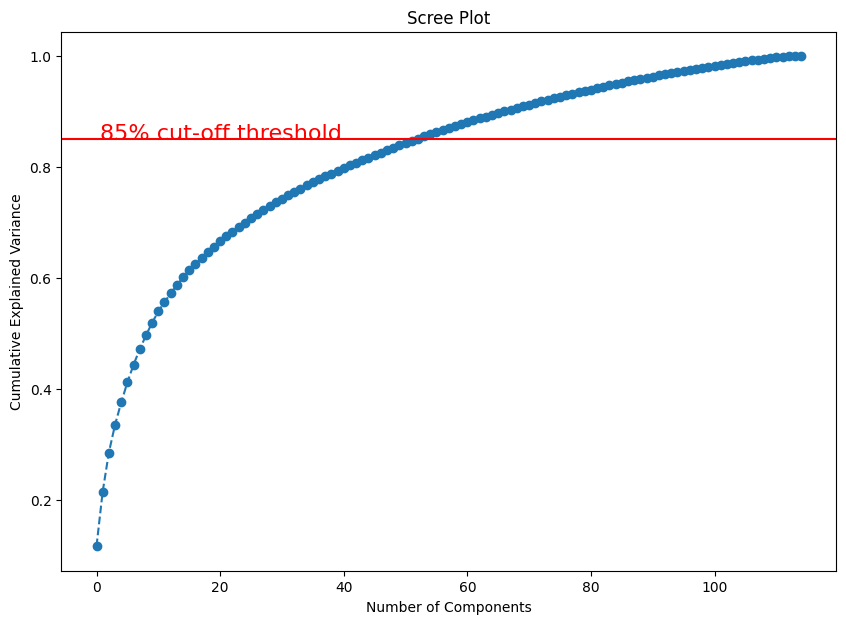

Eigenvalues > 1: 114
Number of Components explaining 85% variance is 53


In [ ]:
# Fit PCA
scaler = StandardScaler()
aml_standard = scaler.fit_transform(aml_X)
pca = PCA().fit(aml_standard)

# Explained variance
explained_variance = pca.explained_variance_ratio_

# Scree plot
plt.figure(figsize=(10, 7))
plt.plot(np.cumsum(explained_variance), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.axhline(y=0.85, color='r', linestyle='-')
plt.text(0.5, 0.85, '85% cut-off threshold', color = 'red', fontsize=16)
plt.show()

# Eigenvalue > 1 (Kaiser Criterion)
eigenvalues = pca.explained_variance_
print("Eigenvalues > 1:", np.sum(eigenvalues > 1))

# Cumulative Explained Variance
cumulative_variance = np.cumsum(explained_variance)
print("Number of Components explaining 85% variance is", np.argmax(cumulative_variance >= 0.85) + 1)

In [ ]:
pca = PCA(n_components=10)
feat_pca = pca.fit_transform(aml_standard)
name_pca = ["X_"+str(i) for i in range(feat_pca.shape[1])]
aml_pca = pd.DataFrame(data = feat_pca, columns=name_pca)
aml_pca['time'] = aml['A1']
aml_pca['status'] = aml['A2']
aml_pca

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,time,status
0,-9.922334,21.801530,-12.595070,25.250825,2.594539,-37.017418,-23.075548,-12.105010,18.348359,2.826738,3,1
1,1.777465,-79.017059,23.664913,-30.095558,-10.609897,-3.336474,-23.136577,2.244751,-2.158721,4.208959,243,1
2,-43.514862,-18.376371,10.907179,15.267841,0.448678,-1.272114,-0.451619,-0.793074,7.395003,-20.576370,711,1
3,-16.346075,-18.289720,-12.694691,-8.018754,9.841654,-3.138906,8.743777,-3.051754,11.678909,-19.277508,663,1
4,54.621940,15.792990,0.943651,-3.640506,5.426009,13.289977,-2.841975,-0.373941,6.523835,8.234438,720,0
...,...,...,...,...,...,...,...,...,...,...,...,...
110,25.643013,-7.620047,-32.927898,-10.482508,-13.065405,-16.094078,6.548044,18.925257,11.321489,6.744175,206,0
111,-12.317186,-50.390685,-7.154549,-1.790278,-51.106851,14.039141,-6.240121,24.599703,9.536407,12.427053,622,0
112,0.007221,9.961546,5.817492,-5.834330,-15.784624,23.131726,36.815974,-34.807242,-0.690249,4.590986,281,1
113,-51.516748,30.562363,-22.878288,-17.949092,-61.395916,26.586240,0.834228,-37.951031,-18.984322,8.901338,33,1


In [ ]:
X_train, X_test, E_train, E_test, Y_train, Y_test = train_test_split(aml_pca[name_pca], aml_pca['status'], aml_pca['time'], test_size=0.25, random_state=17)
aft_weibull_imp = WeibullAFTFitter()
aft_weibull_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_weibull_imp.print_summary()
print("C-Index for testing= ", aft_weibull_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.WeibullAFTFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 86
number of events observed = 52
           log-likelihood = -376.41
         time fit was run = 2024-07-13 19:49:23 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ X_0        0.01      1.01      0.01            0.00            0.02                1.00                1.02
        X_1       -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
        X_2       -0.01      0.99      0.01           -0.03            0.00                0.98                1.00
        X_3        0.00      1.00      0.01           -0.01            0.02                0.99                1.02
        X_4        0.01      1.01      0.01           -0.01            0.03                0.99                1.03
        X_5       -0.00      1.00      0.01           -0.02            0.02                0.98                1.02
        X_6       -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
        X_7        0.02      1.02      0.01            0.00            0.04                1.00                1.05
        X_8       -0.03      0.97      0.02           -0.06            0.00                0.94                1.00
        X_9       -0.02      0.98      0.01           -0.04            0.00                0.96                1.00
        Intercept  6.51    672.24      0.16            6.19            6.83              486.62              928.66
rho_    Intercept -0.12      0.89      0.14           -0.41            0.16                0.67                1.18

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ X_0          0.00  2.41   0.02      5.98
        X_1          0.00 -1.00   0.32      1.65
        X_2          0.00 -1.88   0.06      4.05
        X_3          0.00  0.39   0.70      0.52
        X_4          0.00  1.29   0.20      2.35
        X_5          0.00 -0.30   0.76      0.39
        X_6          0.00 -1.47   0.14      2.82
        X_7          0.00  2.21   0.03      5.22
        X_8          0.00 -1.73   0.08      3.58
        X_9          0.00 -1.72   0.09      3.56
        Intercept    0.00 39.49 <0.005       inf
rho_    Intercept    0.00 -0.84   0.40      1.32
---
Concordance = 0.64
AIC = 776.83
log-likelihood ratio test = 18.43 on 10 df
-log2(p) of ll-ratio test = 4.38

C-Index for testing=  0.7250859106529209


In [ ]:
aft_loglogistic_imp = LogLogisticAFTFitter()
aft_loglogistic_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_loglogistic_imp.print_summary()
print("C-Index for testing= ", aft_loglogistic_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.LogLogisticAFTFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 86
number of events observed = 52
           log-likelihood = -381.36
         time fit was run = 2024-07-13 19:49:25 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
alpha_ X_0        0.01      1.01      0.01            0.00            0.02                1.00                1.02
       X_1       -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
       X_2       -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
       X_3        0.00      1.00      0.01           -0.02            0.02                0.98                1.02
       X_4        0.01      1.01      0.01           -0.01            0.03                0.99                1.03
       X_5       -0.00      1.00      0.01           -0.03            0.03                0.97                1.03
       X_6       -0.01      0.99      0.01           -0.04            0.01                0.96                1.01
       X_7        0.02      1.02      0.01           -0.00            0.05                1.00                1.05
       X_8       -0.02      0.98      0.02           -0.06            0.02                0.94                1.02
       X_9       -0.01      0.99      0.01           -0.04            0.01                0.96                1.01
       Intercept  6.09    441.65      0.20            5.70            6.48              298.49              653.46
beta_  Intercept  0.04      1.04      0.16           -0.28            0.35                0.76                1.43

                  cmp to     z      p  -log2(p)
param  covariate                               
alpha_ X_0          0.00  2.08   0.04      4.74
       X_1          0.00 -0.85   0.40      1.33
       X_2          0.00 -1.73   0.08      3.57
       X_3          0.00  0.04   0.97      0.04
       X_4          0.00  0.62   0.54      0.90
       X_5          0.00 -0.04   0.97      0.05
       X_6          0.00 -0.94   0.35      1.53
       X_7          0.00  1.71   0.09      3.51
       X_8          0.00 -1.13   0.26      1.96
       X_9          0.00 -1.05   0.29      1.76
       Intercept    0.00 30.47 <0.005    674.98
beta_  Intercept    0.00  0.24   0.81      0.30
---
Concordance = 0.64
AIC = 786.71
log-likelihood ratio test = 11.40 on 10 df
-log2(p) of ll-ratio test = 1.61

C-Index for testing=  0.7010309278350515


In [ ]:
aft_lognormal_imp = LogNormalAFTFitter()
aft_lognormal_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_lognormal_imp.print_summary()
print("C-Index for testing= ", aft_lognormal_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.LogNormalAFTFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 86
number of events observed = 52
           log-likelihood = -384.82
         time fit was run = 2024-07-13 19:49:26 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
mu_    X_0        0.02      1.02      0.01            0.00            0.03                1.00                1.03
       X_1       -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
       X_2       -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
       X_3       -0.00      1.00      0.01           -0.03            0.02                0.97                1.02
       X_4       -0.00      1.00      0.01           -0.03            0.02                0.97                1.02
       X_5        0.01      1.01      0.01           -0.02            0.03                0.98                1.04
       X_6       -0.01      0.99      0.01           -0.04            0.02                0.96                1.02
       X_7        0.03      1.03      0.01            0.00            0.06                1.00                1.06
       X_8       -0.03      0.97      0.02           -0.07            0.01                0.93                1.01
       X_9       -0.02      0.98      0.01           -0.04            0.01                0.96                1.01
       Intercept  6.00    403.97      0.22            5.56            6.44              260.96              625.35
sigma_ Intercept  0.64      1.90      0.14            0.37            0.91                1.45                2.48

                  cmp to     z      p  -log2(p)
param  covariate                               
mu_    X_0          0.00  2.53   0.01      6.45
       X_1          0.00 -0.65   0.51      0.96
       X_2          0.00 -1.09   0.28      1.86
       X_3          0.00 -0.36   0.72      0.48
       X_4          0.00 -0.21   0.84      0.26
       X_5          0.00  0.41   0.69      0.55
       X_6          0.00 -0.65   0.51      0.96
       X_7          0.00  1.98   0.05      4.39
       X_8          0.00 -1.50   0.13      2.90
       X_9          0.00 -1.10   0.27      1.87
       Intercept    0.00 26.92 <0.005    527.74
sigma_ Intercept    0.00  4.68 <0.005     18.42
---
Concordance = 0.63
AIC = 793.63
log-likelihood ratio test = 10.76 on 10 df
-log2(p) of ll-ratio test = 1.41

C-Index for testing=  0.6804123711340206


In [ ]:
#Buat label RSF
dt = [('cens', '?'), ('time', '<f8')]
Y_ = []
for i, a in enumerate(aml_pca['time']):
  if aml_pca['status'][i]==1:
    Y_.append((True, a))
  else:
    Y_.append((False, a))

Y_ar = np. array(Y_, dtype=dt)
Y_ar

array([( True, 3.000e+00), ( True, 2.430e+02), ( True, 7.110e+02),
       ( True, 6.630e+02), (False, 7.200e+02), ( True, 5.700e+02),
       (False, 5.780e+02), ( True, 4.400e+01), ( True, 4.290e+02),
       (False, 9.800e+02), ( True, 2.150e+02), (False, 7.450e+02),
       ( True, 3.340e+02), (False, 1.380e+02), (False, 1.336e+03),
       (False, 8.390e+02), (False, 2.710e+02), (False, 2.110e+02),
       (False, 1.107e+03), ( True, 3.260e+02), ( True, 1.000e+00),
       ( True, 9.900e+01), ( True, 3.160e+02), (False, 1.388e+03),
       ( True, 8.500e+01), ( True, 1.220e+03), ( True, 1.260e+02),
       ( True, 1.200e+01), ( True, 2.100e+01), (False, 4.930e+02),
       (False, 8.830e+02), ( True, 7.800e+01), ( True, 3.360e+02),
       ( True, 6.720e+02), ( True, 1.420e+02), ( True, 2.500e+02),
       ( True, 5.110e+02), (False, 7.120e+02), ( True, 2.130e+02),
       ( True, 2.330e+02), (False, 4.220e+02), (False, 4.590e+02),
       ( True, 2.110e+02), (False, 3.650e+02), (False, 2.110e+

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(aml_pca[name_pca], Y_ar, test_size=0.25, random_state=17)
rsf_aml1 = RandomSurvivalForest(n_estimators=70,
                           min_samples_split=3,
                           min_samples_leaf=10,
                           max_features="sqrt",
                           n_jobs=-1, random_state=1)
rsf_aml1.fit(X_train, Y_train)
c_rsf1 = rsf_aml1.score(X_test, Y_test)
print("C-Index = ", c_rsf1)

C-Index =  0.7079037800687286


# Factor Analysis

In [ ]:
FA = FactorAnalysis(n_components=15, random_state=0)
feat_fa = FA.fit_transform(aml_standard)
name_fa = ["X_"+str(i) for i in range(feat_fa.shape[1])]
aml_fa = pd.DataFrame(data = feat_fa, columns=name_fa)
aml_fa['time'] = aml['A1']
aml_fa['status'] = aml['A2']
aml_fa

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,time,status
0,-0.372714,-1.042455,-0.568610,1.170092,0.256289,2.699311,1.322880,0.443559,-1.666507,-0.653749,1.349183,-0.533723,-0.548408,-1.789405,-0.474011,3,1
1,0.102347,3.415567,0.581455,-1.611959,0.726242,0.233565,1.528863,-0.181296,0.007066,-0.294963,0.392961,0.058878,-0.470764,0.545632,0.449565,243,1
2,-1.648937,0.718082,0.784848,0.846205,0.031527,0.203973,0.017370,0.076953,-0.531541,1.374830,-1.373300,-0.126159,-1.955471,4.498937,-1.355563,711,1
3,-0.760954,0.667203,-0.725666,-0.144645,-0.778038,-0.041930,-0.816096,0.067679,-1.196000,1.456209,-1.196236,-0.087673,-0.001496,0.933357,0.707354,663,1
4,1.977970,-0.584989,-0.043081,-0.263483,-0.317675,-0.675290,0.292112,-0.064218,-0.267938,-0.957175,-0.311523,0.361922,-1.810878,-0.092866,-0.289307,720,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.728511,0.204495,-1.882889,-0.534190,0.931169,0.854912,-0.897458,-1.556448,-0.479310,-0.387415,-0.743086,1.343162,-0.690126,0.005954,0.278743,206,0
111,-0.564927,1.998755,-0.416973,-0.200845,3.126294,-1.181398,0.413237,-2.005603,0.211476,-1.350710,1.350159,-0.821634,-1.167195,0.476564,-1.214441,622,0
112,0.108344,-0.273549,0.189942,-0.027575,0.468030,-2.109364,-1.809466,2.807255,0.227560,-0.768646,3.398178,1.073443,0.139956,-1.029209,-4.024460,281,1
113,-1.971386,-1.273643,-0.808216,-1.152329,3.577549,-2.486924,0.515029,3.159785,1.217632,-0.677946,2.574334,-0.155938,-0.918422,2.592018,4.812597,33,1


In [ ]:
X_train, X_test, E_train, E_test, Y_train, Y_test = train_test_split(aml_fa[name_fa], aml_fa['status'], aml_fa['time'], test_size=0.25, random_state=17)
aft_weibull_imp = WeibullAFTFitter()
aft_weibull_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_weibull_imp.print_summary()
print("C-Index for testing= ", aft_weibull_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.WeibullAFTFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 86
number of events observed = 52
           log-likelihood = -373.23
         time fit was run = 2024-07-13 19:49:31 UTC

---
                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                  
lambda_ X_0        0.27      1.31      0.14           -0.01            0.55                0.99                1.74
        X_1        0.05      1.05      0.15           -0.25            0.34                0.78                1.40
        X_10      -0.02      0.98      0.16           -0.33            0.29                0.72                1.34
        X_11      -0.41      0.67      0.14           -0.69           -0.12                0.50                0.88
        X_12       0.02      1.02      0.16           -0.30            0.33                0.74                1.40
        X_13      -0.08      0.92      0.14           -0.36            0.20                0.70                1.22
        X_14      -0.08      0.93      0.14           -0.34            0.19                0.71                1.21
        X_2       -0.29      0.74      0.12           -0.53           -0.06                0.59                0.94
        X_3        0.08      1.08      0.17           -0.25            0.41                0.78                1.50
        X_4       -0.11      0.89      0.13           -0.37            0.14                0.69                1.15
        X_5        0.11      1.12      0.15           -0.19            0.41                0.82                1.51
        X_6        0.28      1.32      0.13            0.02            0.54                1.02                1.71
        X_7       -0.17      0.84      0.14           -0.44            0.10                0.64                1.11
        X_8        0.25      1.28      0.19           -0.11            0.61                0.89                1.85
        X_9        0.20      1.22      0.13           -0.05            0.45                0.96                1.57
        Intercept  6.46    636.44      0.15            6.15            6.76              470.38              861.12
rho_    Intercept -0.08      0.92      0.15           -0.38            0.22                0.68                1.24

                   cmp to     z      p  -log2(p)
param   covariate                               
lambda_ X_0          0.00  1.88   0.06      4.06
        X_1          0.00  0.31   0.76      0.40
        X_10         0.00 -0.13   0.90      0.16
        X_11         0.00 -2.82 <0.005      7.68
        X_12         0.00  0.11   0.91      0.14
        X_13         0.00 -0.57   0.57      0.81
        X_14         0.00 -0.56   0.58      0.80
        X_2          0.00 -2.48   0.01      6.26
        X_3          0.00  0.48   0.63      0.67
        X_4          0.00 -0.86   0.39      1.36
        X_5          0.00  0.71   0.48      1.07
        X_6          0.00  2.13   0.03      4.93
        X_7          0.00 -1.23   0.22      2.19
        X_8          0.00  1.34   0.18      2.47
        X_9          0.00  1.60   0.11      3.18
        Intercept    0.00 41.85 <0.005       inf
rho_    Intercept    0.00 -0.53   0.60      0.75
---
Concordance = 0.67
AIC = 780.46
log-likelihood ratio test = 24.80 on 15 df
-log2(p) of ll-ratio test = 4.24

C-Index for testing=  0.7216494845360825


In [ ]:
aft_loglogistic_imp = LogLogisticAFTFitter()
aft_loglogistic_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_loglogistic_imp.print_summary()
print("C-Index for testing= ", aft_loglogistic_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.LogLogisticAFTFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 86
number of events observed = 52
           log-likelihood = -378.71
         time fit was run = 2024-07-13 19:49:34 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
alpha_ X_0        0.31      1.36      0.18           -0.04            0.66                0.96                1.93
       X_1        0.06      1.06      0.15           -0.24            0.37                0.79                1.44
       X_10      -0.06      0.94      0.27           -0.60            0.47                0.55                1.60
       X_11      -0.43      0.65      0.17           -0.76           -0.09                0.47                0.91
       X_12       0.05      1.05      0.19           -0.33            0.42                0.72                1.52
       X_13      -0.03      0.97      0.18           -0.38            0.33                0.68                1.39
       X_14      -0.02      0.98      0.19           -0.40            0.36                0.67                1.43
       X_2       -0.27      0.76      0.16           -0.59            0.04                0.56                1.04
       X_3        0.02      1.02      0.20           -0.37            0.42                0.69                1.51
       X_4       -0.04      0.96      0.18           -0.40            0.31                0.67                1.37
       X_5        0.05      1.05      0.27           -0.48            0.58                0.62                1.79
       X_6        0.25      1.28      0.19           -0.13            0.62                0.88                1.86
       X_7       -0.20      0.82      0.18           -0.56            0.17                0.57                1.18
       X_8        0.24      1.27      0.25           -0.25            0.73                0.78                2.08
       X_9        0.18      1.20      0.16           -0.14            0.50                0.87                1.66
       Intercept  6.06    427.84      0.19            5.68            6.44              292.46              625.89
beta_  Intercept  0.07      1.07      0.17           -0.26            0.40                0.77                1.50

                  cmp to     z      p  -log2(p)
param  covariate                               
alpha_ X_0          0.00  1.74   0.08      3.62
       X_1          0.00  0.40   0.69      0.54
       X_10         0.00 -0.23   0.82      0.29
       X_11         0.00 -2.50   0.01      6.34
       X_12         0.00  0.24   0.81      0.30
       X_13         0.00 -0.15   0.88      0.19
       X_14         0.00 -0.11   0.91      0.13
       X_2          0.00 -1.72   0.09      3.53
       X_3          0.00  0.11   0.91      0.13
       X_4          0.00 -0.25   0.81      0.31
       X_5          0.00  0.19   0.85      0.24
       X_6          0.00  1.30   0.19      2.36
       X_7          0.00 -1.06   0.29      1.79
       X_8          0.00  0.95   0.34      1.56
       X_9          0.00  1.12   0.26      1.92
       Intercept    0.00 31.22 <0.005    708.17
beta_  Intercept    0.00  0.43   0.67      0.58
---
Concordance = 0.68
AIC = 791.41
log-likelihood ratio test = 16.70 on 15 df
-log2(p) of ll-ratio test = 1.57

C-Index for testing=  0.7044673539518901


In [ ]:
aft_lognormal_imp = LogNormalAFTFitter()
aft_lognormal_imp.fit(pd.concat([X_train, E_train, Y_train], axis=1), duration_col='time', event_col='status', robust=True)
aft_lognormal_imp.print_summary()
print("C-Index for testing= ", aft_lognormal_imp.score(pd.concat([X_test, E_test, Y_test], axis=1), scoring_method="concordance_index"))

<lifelines.LogNormalAFTFitter: fitted with 86 total observations, 34 right-censored observations>
             duration col = 'time'
                event col = 'status'
          robust variance = True
   number of observations = 86
number of events observed = 52
           log-likelihood = -381.39
         time fit was run = 2024-07-13 19:49:36 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param  covariate                                                                                                  
mu_    X_0        0.44      1.56      0.18            0.10            0.79                1.10                2.20
       X_1        0.08      1.09      0.16           -0.24            0.40                0.79                1.50
       X_10      -0.20      0.82      0.28           -0.75            0.35                0.47                1.42
       X_11      -0.57      0.57      0.22           -1.00           -0.13                0.37                0.88
       X_12       0.08      1.08      0.21           -0.33            0.49                0.72                1.62
       X_13      -0.02      0.98      0.18           -0.37            0.33                0.69                1.38
       X_14       0.04      1.04      0.20           -0.36            0.43                0.70                1.54
       X_2       -0.26      0.77      0.21           -0.67            0.16                0.51                1.17
       X_3       -0.06      0.94      0.20           -0.45            0.34                0.64                1.40
       X_4        0.11      1.11      0.22           -0.33            0.55                0.72                1.73
       X_5       -0.10      0.90      0.25           -0.60            0.39                0.55                1.47
       X_6        0.22      1.24      0.20           -0.18            0.61                0.83                1.85
       X_7       -0.26      0.77      0.20           -0.65            0.13                0.52                1.14
       X_8        0.36      1.44      0.25           -0.12            0.85                0.89                2.33
       X_9        0.23      1.26      0.17           -0.11            0.57                0.89                1.78
       Intercept  5.98    396.80      0.22            5.56            6.41              260.26              604.96
sigma_ Intercept  0.60      1.82      0.13            0.35            0.85                1.42                2.33

                  cmp to     z      p  -log2(p)
param  covariate                               
mu_    X_0          0.00  2.51   0.01      6.37
       X_1          0.00  0.50   0.62      0.70
       X_10         0.00 -0.71   0.48      1.07
       X_11         0.00 -2.54   0.01      6.51
       X_12         0.00  0.36   0.72      0.48
       X_13         0.00 -0.12   0.90      0.15
       X_14         0.00  0.18   0.86      0.22
       X_2          0.00 -1.22   0.22      2.16
       X_3          0.00 -0.29   0.77      0.38
       X_4          0.00  0.47   0.64      0.65
       X_5          0.00 -0.42   0.68      0.56
       X_6          0.00  1.06   0.29      1.79
       X_7          0.00 -1.30   0.19      2.38
       X_8          0.00  1.47   0.14      2.83
       X_9          0.00  1.33   0.19      2.43
       Intercept    0.00 27.81 <0.005    562.88
sigma_ Intercept    0.00  4.74 <0.005     18.82
---
Concordance = 0.67
AIC = 796.77
log-likelihood ratio test = 17.61 on 15 df
-log2(p) of ll-ratio test = 1.82

C-Index for testing=  0.7044673539518901


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(aml_fa[name_fa], Y_ar, test_size=0.25, random_state=17)
rsf_aml2 = RandomSurvivalForest(n_estimators=70,
                           min_samples_split=3,
                           min_samples_leaf=10,
                           max_features="sqrt",
                           n_jobs=-1, random_state=1)
rsf_aml2.fit(X_train, Y_train)
c_rsf2 = rsf_aml2.score(X_test, Y_test)
print("C-Index = ", c_rsf2)

C-Index =  0.6529209621993127
